<a href="https://colab.research.google.com/github/Lucy-Moctezuma/SFSU-CodeLab-Work-/blob/main/E.%20Coli%20Machine%20Learning%20Project/2_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Logistic Regression**

# **Objectives**
- Familiarize with the basics of how logistic regression model works.
- Learning how to create functions to implement Logistic Regression in our dataset. 

Logistic Regression is a classification model that allows us to predict the probability for a binary outcome (2 classes). Typically it is expected that the threshold for logistic regression is 0.5; In our example, this means that above this probability, the model would predict R(Resistant) and below this it will predict S(Susceptible).

The equation for Logistic Regression is actually derived from Linear Regression, but instead of Y (Response) we have the natural log of odds: 

$$ ln(\frac{P}{1-P}) = \hat \beta_0 + \hat \beta_jX$$

After isolating P, we end up with the equation below:

$$P = \frac{e^{\hat{\beta}_{0}+\hat{\beta}_{j}X}}{1+e^{\hat{\beta}_{0}+\hat{\beta}_{j}X}}$$

- ***P*** is the probability of an outcome. Therefore P is a number between 0(0%) and 1(100%). Our threshold would be 50%, for our example if P < 0.5 our model would predict Susceptibility (S) and if P > 0.5 our model would predict Resistance (R) 

- $\hat \beta_0$ is the intercept term and $\hat \beta_j = [\beta_1 , \beta_2 , \beta_3, ... , \beta_{18293}]$ all these are the coefficients our model will try to estimate using our data, there is one coefficient per column feature we are using making 18293 of them in our example.

- $X = [Year \ columns + Gene \ Absence \ and \ Presence \ Columns + Population \ Structure \ Columns]$
 
We will see each of the parts of this equation as we go along in the tutorial, so we can have better picture of these.



### **1) Importing Packages needed**


In [ ]:
# Data manipulation imports for ML
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Import packages for logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# Imports for model evaluation 
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Imports for data visualization
import matplotlib.pyplot as plt

# Imports for file management
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **2) Loading CSV file and creating dataframes for each antibiotic**


#### **a) Loading CSV created from previous notebook**


In [45]:
# Loads csv file as a dataframe
filepath = '/content/drive/My Drive/EColi_ML_CSV_files/'

# reads csv file as a dataframe
All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_dfs.csv", na_values="NaN")
All_Drugs_df.head()

<ipython-input-45-8f7183d9b98a>:5: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_dfs.csv", na_values="NaN")


,Isolate,CTZ,CTX,AMP,AMX,AMC,TZP,CXM,CET,GEN,...,cutoff_25459,cutoff_25654,cutoff_25772,cutoff_25979,cutoff_26792,cutoff_27119,cutoff_27236,cutoff_27248,cutoff_27690,cutoff_45092
0,11657_5#10,S,S,S,NaN,S,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
1,11657_5#11,S,S,R,NaN,R,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
2,11657_5#12,S,S,S,NaN,S,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
3,11657_5#13,S,S,R,NaN,R,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
4,11657_5#14,S,S,R,NaN,S,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0


#### **b) Creating dataframes for each drug**

In [54]:
# creating a list of antibiotic names
drug_list = All_Drugs_df.iloc[:,1:13].columns
drug_list

Index(['CTZ', 'CTX', 'AMP', 'AMX', 'AMC', 'TZP', 'CXM', 'CET', 'GEN', 'TBM',
       'TMP', 'CIP'],
      dtype='object')

In [55]:
# creating a function that makes dataframes for each antibiotic and dropping NaN values
def makeDF(drug):
  df_list = [All_Drugs_df[["Isolate",drug]],All_Drugs_df.iloc[:,13:]]
  Drug_df = pd.concat(df_list, axis=1)
  Drug_df = Drug_df.dropna()
  return Drug_df

In [56]:
# implementing function using as example the drug CTZ
CTZ_df = makeDF("CTZ")

# looking at the shape of CTZ dataframe
print("CTZ dataframe shape: ", CTZ_df.shape)

# looking at the first 5 rows of this dataframe
CTZ_df.head()

CTZ dataframe shape:  (1935, 18293)


,Isolate,CTZ,Year_1970.0,Year_1977.0,Year_1994.0,Year_1997.0,Year_1998.0,Year_1999.0,Year_2001.0,Year_2002.0,...,cutoff_25459,cutoff_25654,cutoff_25772,cutoff_25979,cutoff_26792,cutoff_27119,cutoff_27236,cutoff_27248,cutoff_27690,cutoff_45092
0,11657_5#10,S,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11657_5#11,S,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11657_5#12,S,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11657_5#13,S,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11657_5#14,S,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### **3) Separating each Drug Dataframe into 4 sections : Training (features and labels) and Testing (features and labels)**

#### **a) Creating Testing and Training datasets for each antibiotic drug**


In [59]:
# Separating each dataframe into Labels and Features for training and testing data
def Split_train_test(Drug_df,drug, count=True):
  Train_test_dic = {}
  labels = Drug_df[drug]
  features = Drug_df.drop(columns=[drug])
  features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.33, random_state=42, stratify=labels)

  Train_test_dic['labels_train'] = labels_train
  Train_test_dic['features_train'] = features_train
  Train_test_dic['labels_test'] = labels_test
  Train_test_dic['features_test'] = features_test
  if count == True:
    print(drug)
    for k, df in Train_test_dic.items():
      print(k, df.shape)
      if k.startswith('labels'):
        print(df.value_counts())
  return Train_test_dic

In [60]:
# Implementing the function Split_train_test() for CTZ example
CTZ_Train_test_dic = Split_train_test(CTZ_df,"CTZ")

CTZ
labels_train (1296,)
S    1119
R     177
Name: CTZ, dtype: int64
features_train (1296, 18292)
labels_test (639,)
S    551
R     88
Name: CTZ, dtype: int64
features_test (639, 18292)


### **4) Creating different combination of features before training**


In [63]:
# making a list of combinations of data sources we would like to test in our ML models
combo_list = ['G', 'S', 'GY', 'SY', 'GS', 'GYS'] 

# making a function that creates different feature combinations of the predictor features
def combo_feat(features_df, combo):

  # creating Year column filters for features_df
  year_filter = [col for col in features_df if col.startswith("Year")]
  year_feat = features_df[year_filter]

  # creating Population structure column filters for features_df
  pop_str_filter = [col for col in features_df if col.startswith("cutoff")]
  pop_struc_feat = features_df[pop_str_filter]

  # creating Gene precence column filters for features_df
  gene_presc_filter = [col for col in features_df.columns if col not in pop_str_filter and col not in year_filter and col != "Isolate"]
  gene_presc_feat = features_df[gene_presc_filter]  

  if combo == 'G':
    df_list = [features_df['Isolate'], gene_presc_feat]
    G_feat_df = pd.concat(df_list, axis=1)
    G_feat_df = G_feat_df.drop(columns=['Isolate'])
    return G_feat_df

  if combo == 'S':
    df_list = [features_df['Isolate'], pop_struc_feat]
    S_feat_df = pd.concat(df_list, axis=1)
    S_feat_df = S_feat_df.drop(columns=['Isolate'])
    return S_feat_df

  if combo == 'GY':
    df_list = [features_df['Isolate'], gene_presc_feat, year_feat]
    GY_feat_df = pd.concat(df_list, axis=1)
    GY_feat_df = GY_feat_df.drop(columns=['Isolate'])
    return GY_feat_df

  if combo == 'SY':
    df_list = [features_df['Isolate'], pop_struc_feat, year_feat]
    SY_feat_df = pd.concat(df_list, axis=1)
    SY_feat_df = SY_feat_df.drop(columns=['Isolate'])
    return SY_feat_df

  if combo == 'GS':
    df_list = [features_df['Isolate'], gene_presc_feat, pop_struc_feat]
    GS_feat_df = pd.concat(df_list, axis=1)
    GS_feat_df = GS_feat_df.drop(columns=['Isolate'])
    return GS_feat_df

  if combo == 'GYS':
    df_list = [features_df['Isolate'], gene_presc_feat, year_feat, pop_struc_feat]
    GYS_feat_df = pd.concat(df_list, axis=1)
    GYS_feat_df = GYS_feat_df.drop(columns=['Isolate'])
    return GYS_feat_df

In [64]:
# Implementing combo_feat() function created for training data
CTZ_GYS_train_df = combo_feat(CTZ_Train_test_dic['features_train'],"GYS")

# looking only at the feature column names for the combination for "GYS" for drug "CTZ" for training data
CTZ_GYS_train_df.columns

Index(['yeiU', 'yhhS', 'ybaE', 'eutR', 'ibrB', 'ytfP', 'aslB', 'narQ', 'tolR',
       'galM',
       ...
       'cutoff_25459', 'cutoff_25654', 'cutoff_25772', 'cutoff_25979',
       'cutoff_26792', 'cutoff_27119', 'cutoff_27236', 'cutoff_27248',
       'cutoff_27690', 'cutoff_45092'],
      dtype='object', length=18291)

### **5) Creating Logistic regression model, training and making predictions per feature combination**

Below we can use the function **combo_feat()** created in the previous part, in order choose the correct training and testing features based on the combo we choose to train our Logistic Regression model. 

In [85]:
# creating Logistic regression model function
@ignore_warnings(category=ConvergenceWarning)
def run_LG(Train_test_dic, drug, combo):
  
  # creating correct combo of features to train the model
  feat_train_df = combo_feat(Train_test_dic['features_train'], combo)
  LG = LogisticRegression(random_state = 42, solver= 'lbfgs', C=1.0, max_iter=500, class_weight='balanced')
  print(drug +" Training combo: "+ combo) 
  LG = LG.fit(feat_train_df, Train_test_dic['labels_train'])
  
  # creating correct combo of test features to use model and make predictions
  feat_test_df = combo_feat(Train_test_dic['features_test'], combo)
  pred = LG.predict(feat_test_df)
  print("Prediction Results for:", combo, np.unique(pred, return_counts=True))
  
  return {'drug':drug, 'combo':combo, 'model':LG, 'predictions':pred, 'actual_labels':Train_test_dic['labels_test']}

In [86]:
# implementing run_LG() for specific drug feature combination dataframe
LG_CTZ_GYS_model = run_LG(CTZ_Train_test_dic,"CTZ","GYS")
LG_CTZ_GYS_model['model']

CTZ Training combo: GYS
Prediction Results for: GYS (array(['R', 'S'], dtype=object), array([120, 519]))


LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)

Below we can see that our model contains several coefficients. We will printout first the intercept ($\hat{\beta}_{0}$), then a list of the coefficients that correspond to each column feature ($\hat{\beta}_{j}$) and finally we can get a print out of the total number of coefficients in our model, these should be the same number as all the features we used in this example.

In [87]:
# printing the beta_0 or intercept value of our model
print("Intercept:",LG_CTZ_GYS_model['model'].intercept_[0])

# printing all the beta_j's or coefficients of our logistic regression model
print("All beta_j values:", LG_CTZ_GYS_model['model'].coef_[0])

# printing the number of all the beta_j values
print("Number of beta_j values: ", len(LG_CTZ_GYS_model['model'].coef_[0]))

Intercept: -0.000337459909156827
All beta_j values: [-3.37450389e-04 -3.37450389e-04 -3.37450389e-04 ... -1.19712689e-04
 -5.98908475e-05  0.00000000e+00]
Number of beta_j values:  18291


### **6) Evaluating our model using a confusion matrix and other metrics**

There are different metrics we can use to evaluate our model. For this tutorial however we will only focus on four of them:

- **Accuracy:** is the number of correct classifications over the total amount of predictions made.

- **Recall:** is the number of correct classifications made for a particular class over all predictions of that class.

- **Precision:** is the number of classifications made for a particular class over the actual number of strains for that class.

- **F1 score:** is the harmonic mean of the Recall and Precision. Because these metrics tend to have an inverse relationship, the F1 score takes in consideration both metrics. In this case because our data is inbalanced, accuracy might be misleading and F1 score is a good measure of how well overall the model performs for a particular class. 

In [101]:
# Creating a function that evaluates our model using our actual and predicted data
def evaluate(LG_combo_model, cf= True, show_results=True):
  report = classification_report(LG_combo_model['actual_labels'], LG_combo_model['predictions'], output_dict = True)
  if cf == True:
    cm = confusion_matrix(LG_combo_model['actual_labels'], LG_combo_model['predictions'], labels=LG_combo_model['model'].classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LG_combo_model['model'].classes_)
    disp.plot()
    plt.show()
  if show_results == True:
    report2 = classification_report(LG_combo_model['actual_labels'], LG_combo_model['predictions'], output_dict = False)
    print(report2)
  return [report['accuracy'],report['R']['recall'], report['S']['recall'], report['R']['precision'], report['S']['precision'], report['R']['f1-score'], report['S']['f1-score']]

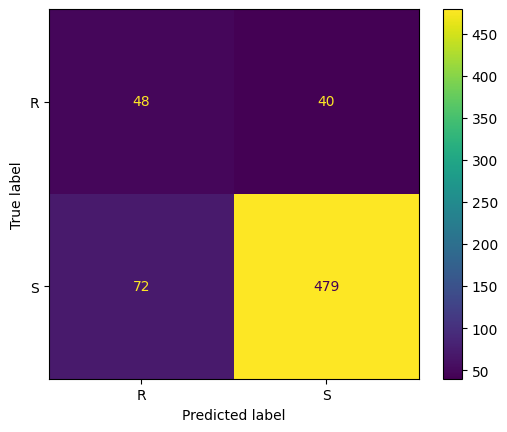

              precision    recall  f1-score   support

           R       0.40      0.55      0.46        88
           S       0.92      0.87      0.90       551

    accuracy                           0.82       639
   macro avg       0.66      0.71      0.68       639
weighted avg       0.85      0.82      0.84       639



In [103]:
# implementing the evaluate() function 
Model_Report = evaluate(LG_CTZ_GYS_model)

Above we can see an output of our function, below we can show a manual way in which some of these metrics are being calculated:

**NOTE:** A confusion matrix contains True Positives (TP), True Negatives (TN), False Positives (FP) and False Negatives (FN). In this case since we have 2 classes. **Positives** in this case means R, **Negatives** in this case means S

- **TP** = Correctly Classified Resistance (R) = 48
- **TN** = Correctly Classified Susceptible (S) = 479
- **FP** = Incorrectly Classified Resistance (R) = 72
- **FN** = Incorrectly Classified Susceptible (S) = 40

**Accuracy:** 
$$\frac{TP + TN}{All \ Predicted} = \frac{48 + 479}{639} = 0.8247$$

As an example we will manually look at the calculation of Recall and Presicion for only the **Resistant Strains**:

**R_Recall:**
$$\frac{Correctly \ classified \ R}{All \ Actual \ R} = \frac{TP}{TP + FN} = \frac{48}{48 + 40} = 0.545$$

**R_Precision:**
$$\frac{Correctly \ classified \ R}{All \ Predicted \ R} = \frac{TP}{TP + FP} = \frac{48}{48 + 72} = 0.4$$

**R_F1-score:**
$$\frac{2}{R \ Recall^{-1} + R \ Precision^{-1}} = \frac{2*TP}{2*TP + FP + FN} = 0.46$$

### **8) Use all functions and evaluate every drug in every feature combination!**

#### **a) Lets recall the list of drugs we have available and the combination of features we are interested in**

In [108]:
# let's check all drugs
print(drug_list)

# let's see all combinations we are interested in
print(combo_list)

Index(['CTZ', 'CTX', 'AMP', 'AMX', 'AMC', 'TZP', 'CXM', 'CET', 'GEN', 'TBM',
       'TMP', 'CIP'],
      dtype='object')
['G', 'S', 'GY', 'SY', 'GS', 'GYS']


#### **b) Create a loop that will go through all our functions using the lists above**

In [111]:
# Lets use all our functions this time and save our report into a single data structure
LG_model_metrics = {}

for drug in drug_list:
  print(drug)
  Drug_df = makeDF(drug) # creates one df per drug
  Test_Train_dic = Split_train_test(Drug_df, drug, count=False) # splits each drug df into a dictionary with testing and training data
  for combo in combo_list:
    # Running, training and predicting with the model using all the feature combos
    LG_combo_model = run_LG(Test_Train_dic, drug, combo)
    # Evaluating our models 
    Results = evaluate(LG_combo_model, cf=False, show_results=False)
    LG_model_metrics[drug+"_"+combo] = Results
    print(Results)

CTZ
CTZ Training combo: G
Prediction Results for: G (array(['R', 'S'], dtype=object), array([ 72, 567]))
[0.9405320813771518, 0.6931818181818182, 0.9800362976406534, 0.8472222222222222, 0.9523809523809523, 0.7625000000000001, 0.9660107334525938]
CTZ Training combo: S
Prediction Results for: S (array(['R', 'S'], dtype=object), array([118, 521]))
[0.8184663536776213, 0.5113636363636364, 0.867513611615245, 0.3813559322033898, 0.9174664107485605, 0.4368932038834951, 0.8917910447761194]
CTZ Training combo: GY
Prediction Results for: GY (array(['R', 'S'], dtype=object), array([ 75, 564]))
[0.945226917057903, 0.7272727272727273, 0.9800362976406534, 0.8533333333333334, 0.9574468085106383, 0.785276073619632, 0.968609865470852]
CTZ Training combo: SY
Prediction Results for: SY (array(['R', 'S'], dtype=object), array([122, 517]))
[0.8184663536776213, 0.5340909090909091, 0.8638838475499092, 0.38524590163934425, 0.9206963249516441, 0.4476190476190476, 0.8913857677902621]
CTZ Training combo: GS
Pred

#### **b) Store the metrics report for all drugs and features combinations as a csv file**

In [112]:
# convert dictionary into a dataframe
LG_metrics = pd.DataFrame.from_dict(LG_model_metrics, orient='index',columns=["Accuracy", "R_recall", "S_recall", "R_precision", "S_precision", "R_f1_score", "S_f1_score"]).reset_index()
LG_metrics = LG_metrics.rename(columns = {'index':'Drug_combo'})

# saving our metric results into a CSV file
LG_metrics.to_csv(filepath+"LG_metrics_df.csv", index= False)
LG_metrics

,Drug_combo,Accuracy,R_recall,S_recall,R_precision,S_precision,R_f1_score,S_f1_score
0,CTZ_G,0.940532,0.693182,0.980036,0.847222,0.952381,0.762500,0.966011
1,CTZ_S,0.818466,0.511364,0.867514,0.381356,0.917466,0.436893,0.891791
2,CTZ_GY,0.945227,0.727273,0.980036,0.853333,0.957447,0.785276,0.968610
3,CTZ_SY,0.818466,0.534091,0.863884,0.385246,0.920696,0.447619,0.891386
4,CTZ_GS,0.824726,0.556818,0.867514,0.401639,0.924565,0.466667,0.895131
...,...,...,...,...,...,...,...,...
67,CIP_S,0.816901,0.767606,0.830986,0.564767,0.926009,0.650746,0.875928
68,CIP_GY,0.932707,0.873239,0.949698,0.832215,0.963265,0.852234,0.956434
69,CIP_SY,0.829421,0.795775,0.839034,0.585492,0.934978,0.674627,0.884411
70,CIP_GS,0.812207,0.753521,0.828974,0.557292,0.921700,0.640719,0.872881


#### **c) Create a bar graph showing accuracies of all drugs when using all features (GYS)**

In [113]:
# filtering for all the rows that contain 
GYS_filter = [drug_combo for drug_combo in LG_metrics['Drug_combo'] if drug_combo.endswith("GYS")]
GYS_df = LG_metrics.loc[LG_metrics["Drug_combo"].isin(GYS_filter)]

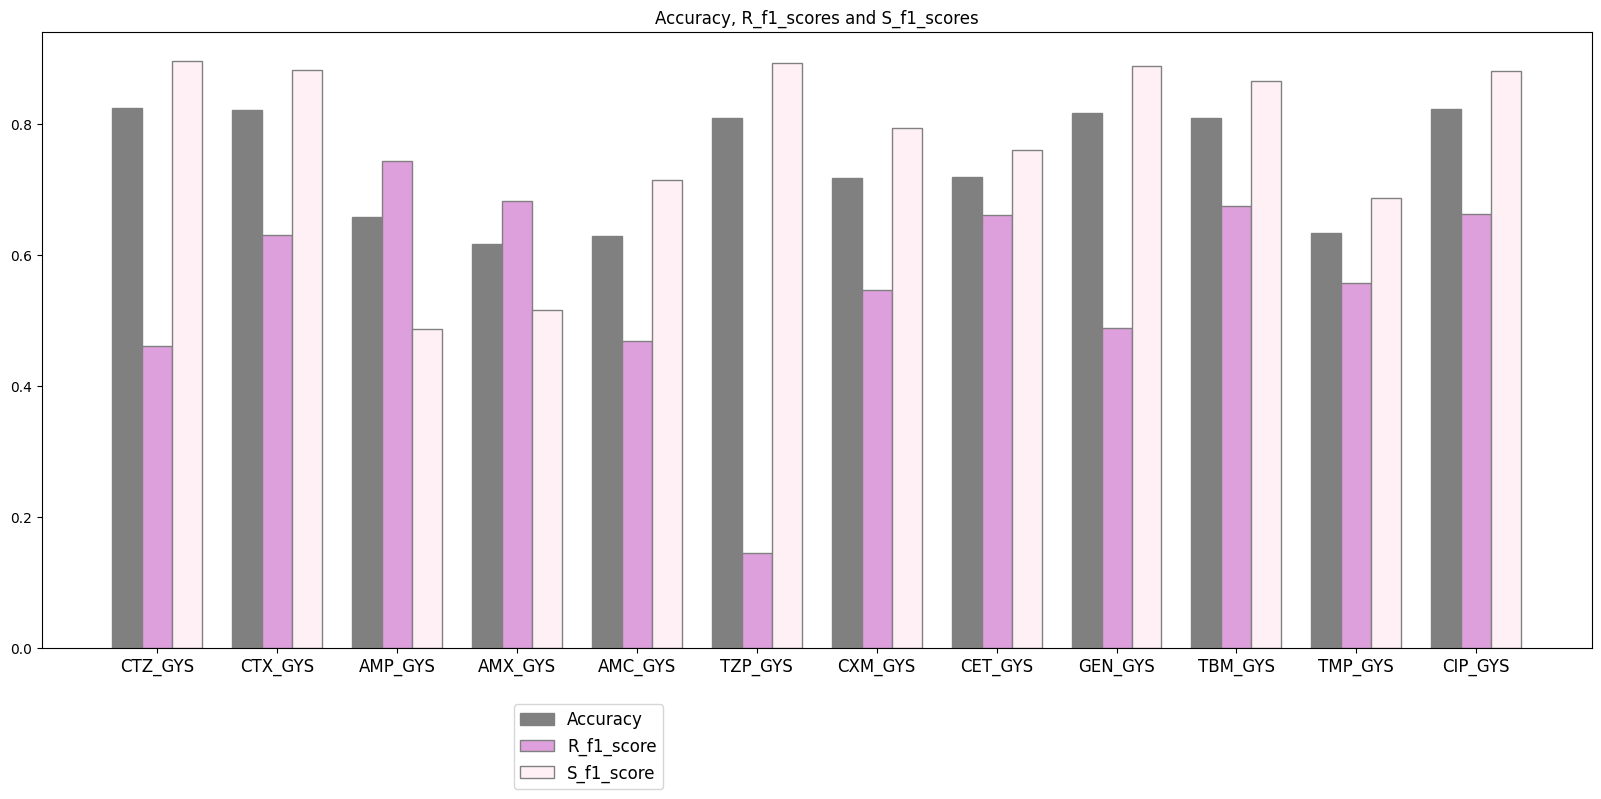

In [115]:
# Figure Size
fig = plt.figure(figsize =(20, 8))

# Adding title
plt.title('Accuracy, R_f1_scores and S_f1_scores', fontsize = 12)

# Variables to be plotted 
x = np.arange(len(GYS_df["Drug_combo"]))
acc = list(GYS_df["Accuracy"])
R_f1 = list(GYS_df["R_f1_score"])
S_f1 = list(GYS_df["S_f1_score"])

# Plotting barcharts
acc_bar=plt.bar(x-0.25, height= acc, width=0.25, color="grey", edgecolor="gray")
rf1_bar=plt.bar(x, height= R_f1, width=0.25, color="plum", align="center", edgecolor="gray")
sf1_bar=plt.bar(x+0.25, height= S_f1, width=0.25, color="lavenderblush", edgecolor="gray")

plt.xticks([r for r in range(len(GYS_df["Drug_combo"]))],
        GYS_df["Drug_combo"], fontsize = 12)

#legend
fig.legend([acc_bar,rf1_bar,sf1_bar],["Accuracy", "R_f1_score", "S_f1_score"], bbox_to_anchor=(0.4,-0.35, 0.04, 0.4), fontsize=12)

# Show Plot
plt.show()